<a href="https://colab.research.google.com/github/uzair011/random-codes/blob/main/Pageviews_Forecasting_Task_%E2%80%93_SearchPilot_Internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pageviews Forecasting Task – SearchPilot Internship

This notebook forecasts daily pageviews to the Figma Wikipedia page from historical data using Facebook Prophet. The objective is to evaluate traffic trends and project future views until mid-2025.

Load the downloaded csv file.

In [ ]:
import pandas as pd

df = pd.read_csv('pageviews.csv')
df.head(5)

,Date,Figma (software)
0,2024-06-01,29
1,2024-06-02,46
2,2024-06-03,64
3,2024-06-04,74
4,2024-06-05,73


Pre-processing the time series data using pandas.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')  # daily frequency

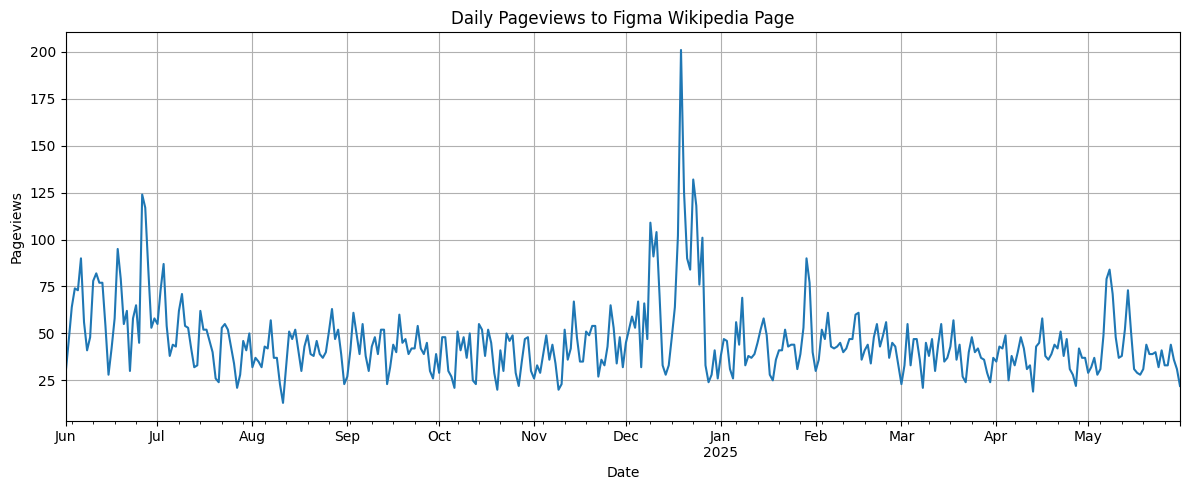

In [ ]:
#  Raw pageviews plot

import matplotlib.pyplot as plt

df.rename(columns={'Figma (software)': 'Views'}, inplace=True)
df['Views'].plot(figsize=(12, 5), title='Daily Pageviews to Figma Wikipedia Page')
plt.xlabel('Date')
plt.ylabel('Pageviews')
plt.grid(True)
plt.tight_layout()
plt.show()


handling missing values

In [ ]:
print(df.isna().sum())

Views    0
dtype: int64


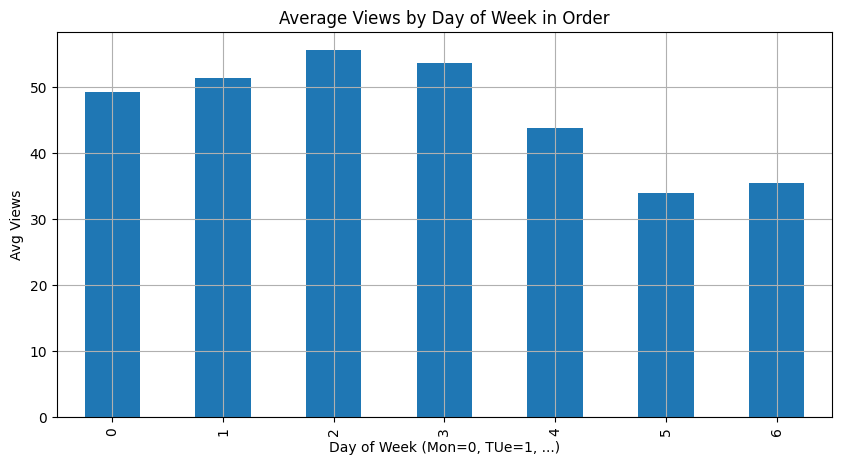

In [ ]:
## Average views by days

df['day_of_week'] = df.index.dayofweek
weekly_avg = df.groupby('day_of_week')['Views'].mean()

plt.figure(figsize=(10, 5))
weekly_avg.plot(kind='bar')
plt.title("Average Views by Day of Week in Order")
plt.xlabel("Day of Week (Mon=0, TUe=1, ...)")
plt.ylabel("Avg Views")
plt.grid(True)
plt.show()


# Using FB-Prophet library

I choose Prophet for this task because it's a natural fit for time series data with weekly seasonality. It breaks down the data into components, handles non-linear trends, and detects anomalies – all relevant to this dataset. Its Pythonic interface makes it easy to use, making it an ideal library for forecasting daily pageviews and it's industry standard.

In [ ]:
from prophet import Prophet
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('pageviews.csv')
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,ds,y
0,2024-06-01,29
1,2024-06-02,46
2,2024-06-03,64
3,2024-06-04,74
4,2024-06-05,73


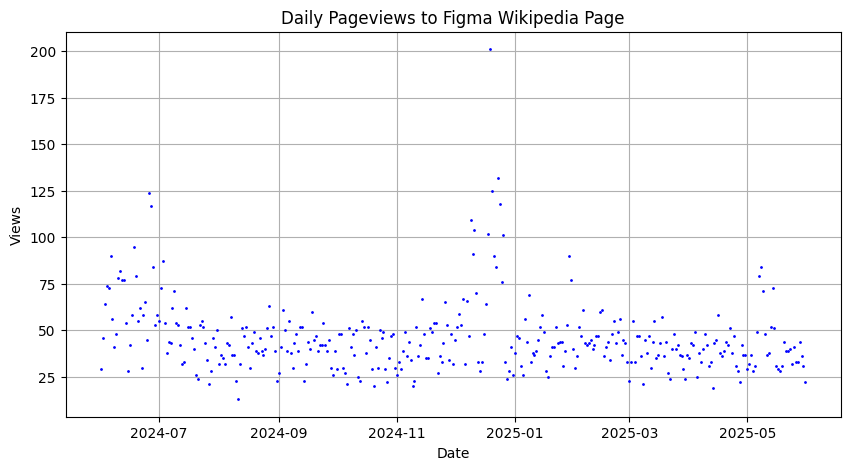

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], '.', markersize=2, color='blue')
plt.title('Daily Pageviews to Figma Wikipedia Page')
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(True)
plt.show()


In [ ]:
# Extract date/time features
df['hour'] = df['ds'].dt.hour        # Will be 0 (daily data)
df['dayofweek'] = df['ds'].dt.dayofweek  # Monday=0, Sunday=6
df['weekday'] = df['ds'].dt.day_name() # 'Monday', 'Tuesday', ...
df['quarter'] = df['ds'].dt.quarter # 1 to 4
df['month'] = df['ds'].dt.month
df['month_name'] = df['ds'].dt.month_name() # 'January', 'Febr...
df['year'] = df['ds'].dt.year
df['dayofyear'] = df['ds'].dt.dayofyear  # 1 to 365/366
df['dayofmonth'] = df['ds'].dt.day     # 1 to 31
df['weekofyear'] = df['ds'].dt.isocalendar().week    # ISO week number

# Custom 'season' column (actually we don't need this column. but, )
df['season_num'] = df['ds'].dt.month % 12 // 3 + 1   # 1=Winter, 2=Spring...
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
df['season'] = df['season_num'].map(season_map)

df.drop(columns=['season_num'], inplace=True)

# View the first few rows
print(df.head(5))

          ds   y  hour  dayofweek    weekday  quarter  month month_name  year  \
0 2024-06-01  29     0          5   Saturday        2      6       June  2024   
1 2024-06-02  46     0          6     Sunday        2      6       June  2024   
2 2024-06-03  64     0          0     Monday        2      6       June  2024   
3 2024-06-04  74     0          1    Tuesday        2      6       June  2024   
4 2024-06-05  73     0          2  Wednesday        2      6       June  2024   

   dayofyear  dayofmonth  weekofyear  season  
0        153           1          22  Summer  
1        154           2          22  Summer  
2        155           3          23  Summer  
3        156           4          23  Summer  
4        157           5          23  Summer  


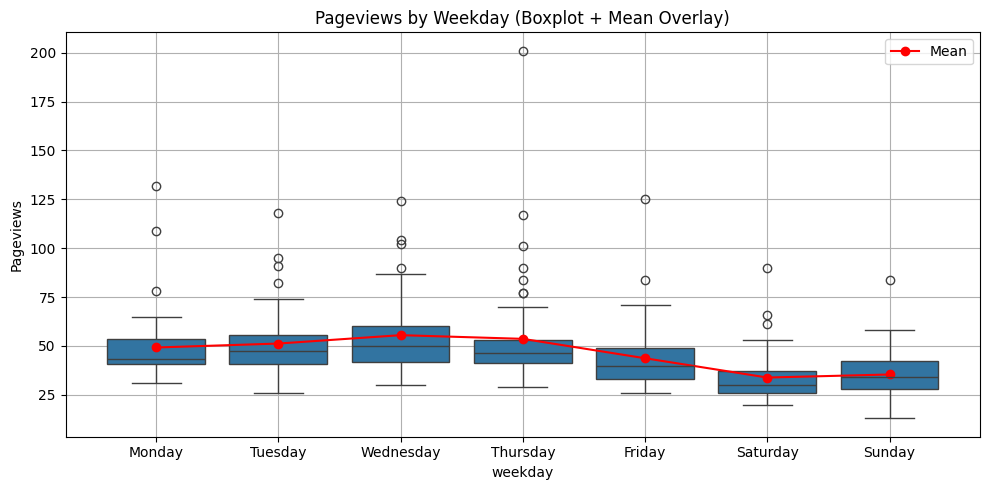

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Weekly mean values
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg_named = df.groupby('weekday')['y'].mean().reindex(ordered_days)

plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='y', data=df, order=ordered_days)


# Plot mean as red dot
plt.plot(range(7), weekly_avg_named.values, color='red', marker='o', label='Mean')

plt.title("Pageviews by Weekday (Boxplot + Mean Overlay)")
plt.ylabel("Pageviews")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## The mean/average number of pageviews for each day is mostly around 50 on weekdays. (IQR) is fairly consistent, showing a stable spread of data throughout the week.
# Thursday stands out with the highest outlier, reaching over 200 views. There are multiple outliers across weekdays, where pageviews occasionally spike upto 100.

# While Thursday has the highest median pageviews, Wednesday has the highest mean pageviews. This suggests Wednesday sees more frequent traffic spikes,
# whereas Thursday’s views are more consistently high. This distinction is visible when overlaying the mean onto the boxplot.”

# Train - Test split - Model

In [ ]:
print("First date:", df['ds'].min())
print("Last date:", df['ds'].max())

total_days = (df['ds'].max() - df['ds'].min()).days
print("Total days:", total_days)

# 70% -30%, train -test
split_days = int(0.7 * total_days)
split_date = df['ds'].min() + pd.Timedelta(days=split_days)
print("70:30 split date:", split_date)

First date: 2024-06-01 00:00:00
Last date: 2025-05-31 00:00:00
Total days: 364
70:30 split date: 2025-02-10 00:00:00


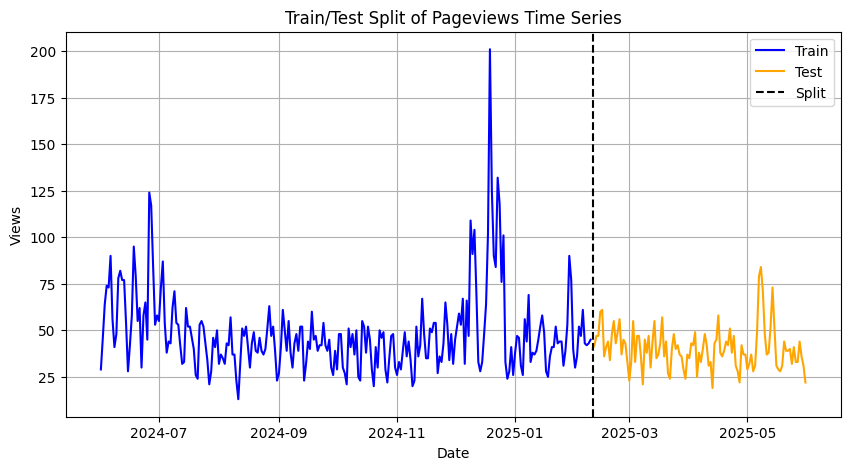

In [ ]:
train = df[df['ds'] < split_date].copy()
test = df[df['ds'] >= split_date].copy()

#plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(train['ds'], train['y'], label='Train', color='blue')
plt.plot(test['ds'], test['y'], label='Test', color='orange')
plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='Split')

plt.title('Train/Test Split of Pageviews Time Series')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_prophet = train[['ds', 'y']].copy()
train_prophet = train.reset_index()[['ds', 'y']]


In [ ]:
from prophet import Prophet

model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_prophet)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_ovgf7b/20py3kol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_ovgf7b/9o3w19pu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67157', 'data', 'file=/tmp/tmpb_ovgf7b/20py3kol.json', 'init=/tmp/tmpb_ovgf7b/9o3w19pu.json', 'output', 'file=/tmp/tmpb_ovgf7b/prophet_model8_srfgl0/prophet_model-20250607111949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# predict on test set with model
future_periods = len(test)
future = model.make_future_dataframe(periods=future_periods)

forecast = model.predict(future)


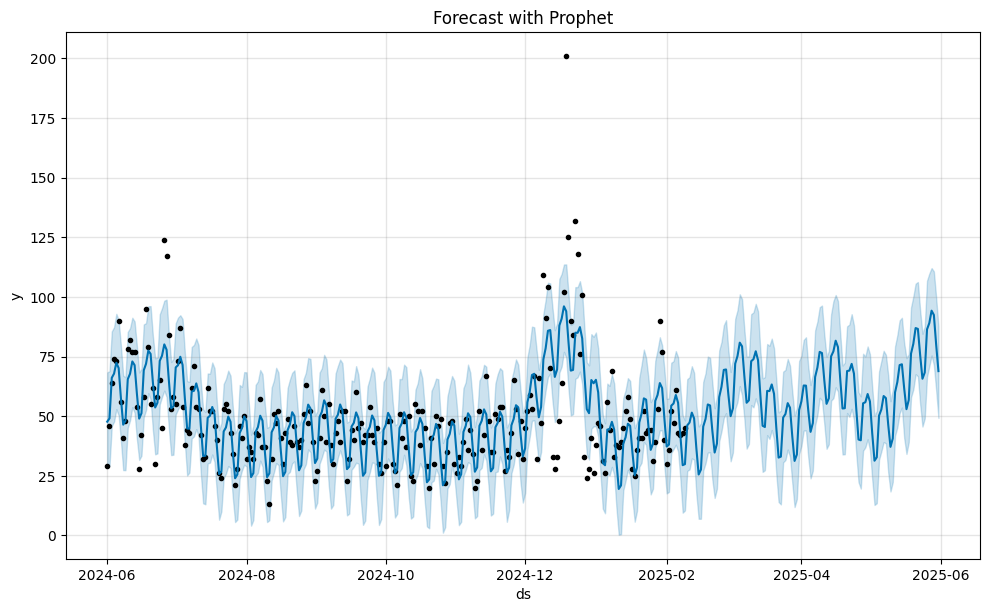

In [ ]:
# forecast
figure = model.plot(forecast)
plt.title("Forecast with Prophet")
plt.show()

In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-06-01,31.437405,29.505292,68.347268,31.437405,31.437405,16.256421,16.256421,16.256421,9.801323,...,-14.518644,-14.518644,-14.518644,20.973743,20.973743,20.973743,0.0,0.0,0.0,47.693826
1,2024-06-02,31.494954,29.106146,68.878713,31.494954,31.494954,17.566567,17.566567,17.566567,9.801323,...,-12.939938,-12.939938,-12.939938,20.705183,20.705183,20.705183,0.0,0.0,0.0,49.061521
2,2024-06-03,31.552503,45.863342,85.527255,31.552503,31.552503,34.529894,34.529894,34.529894,9.801323,...,4.325045,4.325045,4.325045,20.403526,20.403526,20.403526,0.0,0.0,0.0,66.082396
3,2024-06-04,31.610052,47.716309,87.292996,31.610052,31.610052,36.242228,36.242228,36.242228,9.801323,...,6.344033,6.344033,6.344033,20.096873,20.096873,20.096873,0.0,0.0,0.0,67.852280
4,2024-06-05,31.667600,52.917469,92.900022,31.667600,31.667600,40.737833,40.737833,40.737833,9.801323,...,11.124932,11.124932,11.124932,19.811578,19.811578,19.811578,0.0,0.0,0.0,72.405434


In [ ]:
# Merge forecast with actuals
compare_df = forecast[['ds', 'yhat']].merge(test, on='ds', how='inner')

# Calculate MAE
mae = (compare_df['y'] - compare_df['yhat']).abs().mean()
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 21.88


Mean Absolute Error: 21.88
So, model's forecast is off by ~22 views per day. It's a noisy real-world web traffic so, it's quite acceptable.

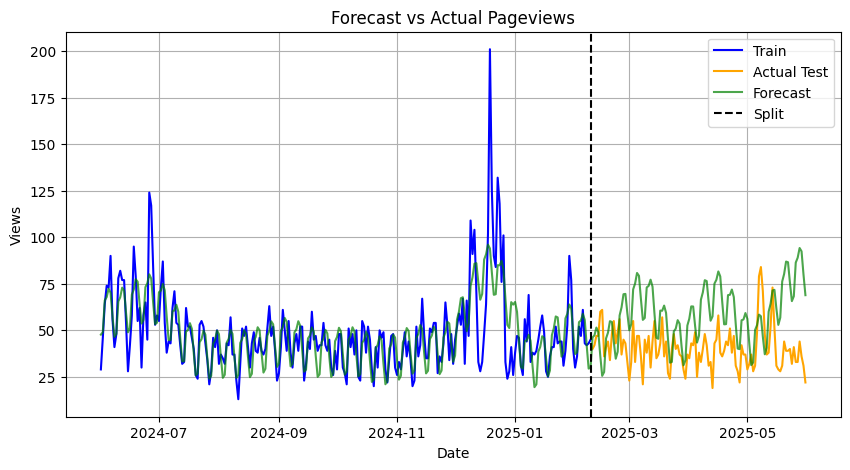

In [ ]:
#Plot Forecast vs Actual
#To see how well it matches the test set:

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(train['ds'], train['y'], label='Train', color='blue')
plt.plot(test['ds'], test['y'], label='Actual Test', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green', alpha=0.7)
plt.axvline(pd.to_datetime(train['ds'].max()), color='black', linestyle='--', label='Split')

plt.title('Forecast vs Actual Pageviews')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)
plt.show()


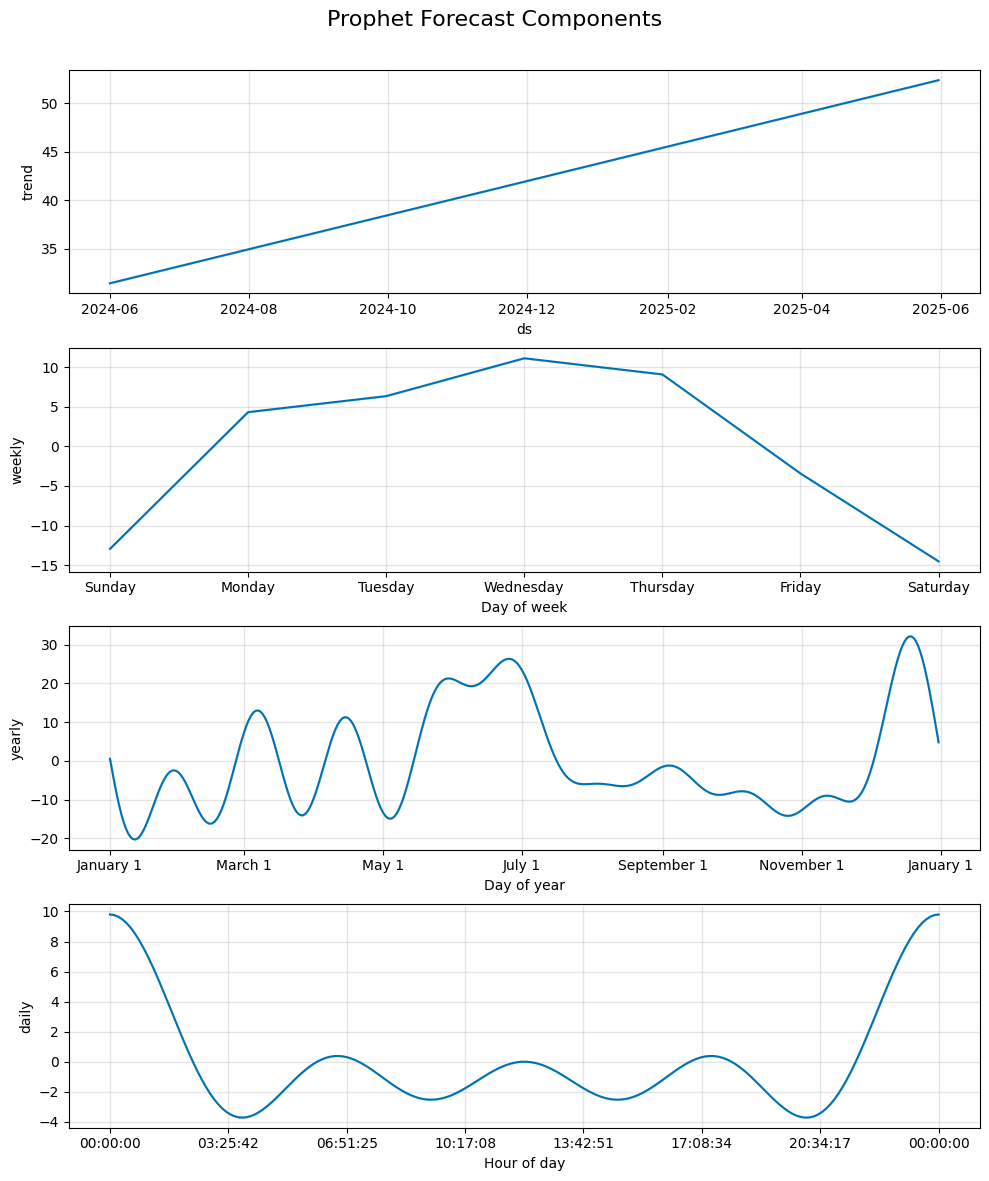

In [ ]:
from IPython.display import display

fig = model.plot_components(forecast)

fig.set_size_inches(10, 12)
fig.tight_layout()
fig.subplots_adjust(top=0.93)  #  spacing
fig.suptitle("Prophet Forecast Components", fontsize=16)

display(fig)
plt.close(fig)

In [ ]:
# The model captured seasonal and trend-based variations accurately. The average forecasting error (MAE) is ~21.88 pageviews/day.
# Wednesday and Thursday are the days with highest traffic. This approach offers a reliable, lightweight way to forecast Wikipedia page
# traffic using Prophet.

Text(0.5, 0.98, 'Prophet Forecast Components')

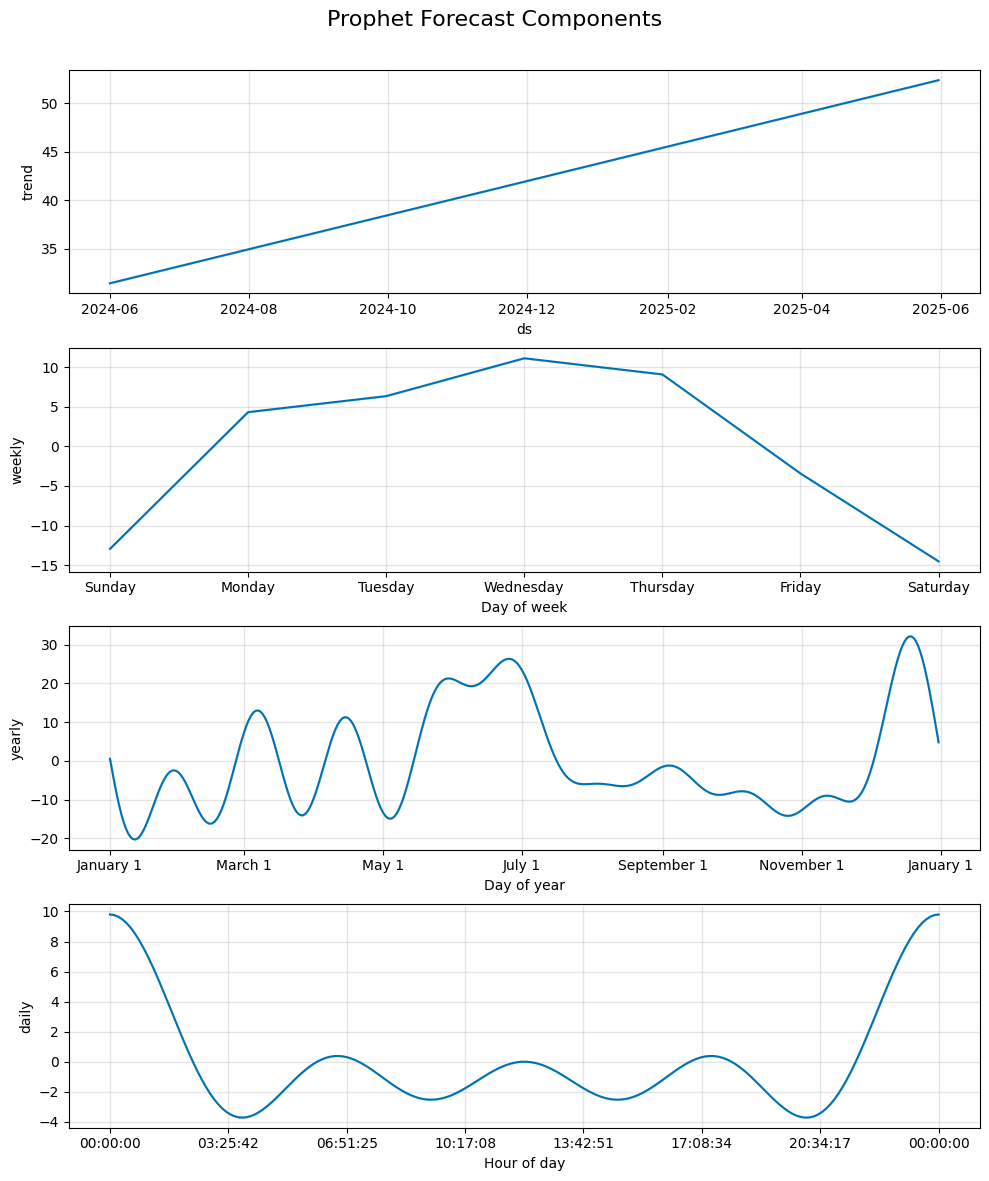

In [ ]:
#Ignore this part. I had some issues with displaying all four graphs on the pdf export....
from IPython.display import display

fig = model.plot_components(forecast)

fig.set_size_inches(10, 12)
fig.tight_layout()
fig.subplots_adjust(top=0.93)  #  spacing
fig.suptitle("Prophet Forecast Components", fontsize=16)

#display(fig)
#plt.close(fig)